# Pytorch实现cifar10多分类

# 1 准备数据

(1)导入模块

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

（2）下载数据集

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


（3）展示数据集

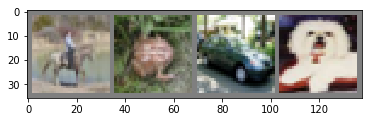

horse  frog   car   dog


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2 构建网络

（1）搭建CNN网络

In [5]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296,128)
        self.fc2 = nn.Linear(128,10)      

    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(-1,36*6*6)
        x=F.relu(self.fc2(F.relu(self.fc1(x))))
        return x

net = CNNNet()
net=net.to(device)

In [6]:
print("net have {} paramerters in total".format(sum(x.numel() for x in net.parameters())))

net have 173742 paramerters in total


（2）设置loss，lr，迭代器

In [7]:
import torch.optim as optim
LR=0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
## 展示网络结构
print(net)

CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
#取模型中的前四层
nn.Sequential(*list(net.children())[:4])

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# 3 训练模型

In [10]:
from tensorboardX import SummaryWriter
writer = SummaryWriter(log_dir='logs',comment='CNN')

for epoch in range(10):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 权重参数梯度清零
        optimizer.zero_grad()

        # 正向及反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 显示损失值
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            writer.add_scalar('train_loss', running_loss / 2000, epoch+1)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.197
[1,  4000] loss: 1.906
[1,  6000] loss: 1.550
[1,  8000] loss: 1.432
[1, 10000] loss: 1.376
[1, 12000] loss: 1.293
[2,  2000] loss: 1.194
[2,  4000] loss: 1.171
[2,  6000] loss: 1.144
[2,  8000] loss: 1.097
[2, 10000] loss: 1.095
[2, 12000] loss: 1.060
[3,  2000] loss: 0.951
[3,  4000] loss: 0.956
[3,  6000] loss: 0.955
[3,  8000] loss: 0.929
[3, 10000] loss: 0.925
[3, 12000] loss: 0.939
[4,  2000] loss: 0.803
[4,  4000] loss: 0.816
[4,  6000] loss: 0.834
[4,  8000] loss: 0.802
[4, 10000] loss: 0.841
[4, 12000] loss: 0.825
[5,  2000] loss: 0.685
[5,  4000] loss: 0.707
[5,  6000] loss: 0.709
[5,  8000] loss: 0.725
[5, 10000] loss: 0.742
[5, 12000] loss: 0.760
[6,  2000] loss: 0.587
[6,  4000] loss: 0.613
[6,  6000] loss: 0.629
[6,  8000] loss: 0.655
[6, 10000] loss: 0.656
[6, 12000] loss: 0.664
[7,  2000] loss: 0.494
[7,  4000] loss: 0.525
[7,  6000] loss: 0.571
[7,  8000] loss: 0.590
[7, 10000] loss: 0.589
[7, 12000] loss: 0.580
[8,  2000] loss: 0.424
[8,  4000] 

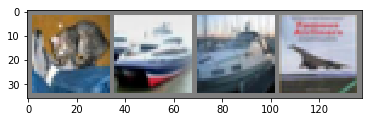

GroundTruth:    cat  ship  ship plane


In [11]:
# 验证集
dataiter = iter(testloader)
images, labels = dataiter.next()
#images, labels = images.to(device), labels.to(device)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

Predicted:    dog  ship  ship plane


# 4 测试模型

（1）计算模型正确率

In [13]:
# 查看准确率
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 67 %


（2）计算每一个目标类的准确率

In [17]:
# 初始化
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 84 %
Accuracy of  bird : 51 %
Accuracy of   cat : 49 %
Accuracy of  deer : 57 %
Accuracy of   dog : 57 %
Accuracy of  frog : 81 %
Accuracy of horse : 71 %
Accuracy of  ship : 74 %
Accuracy of truck : 73 %


# 5 采用全局平均池化

将CNN的池化层后的全连接层换成全局池化

（1）定义网络

In [18]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 36, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.pool2 = nn.MaxPool2d(2, 2)
        #使用全局平均池化层
        self.aap=nn.AdaptiveAvgPool2d(1)
        self.fc3 = nn.Linear(36, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.aap(x)
        x = x.view(x.shape[0], -1)
        x = self.fc3(x)
        return x

net = Net()
net=net.to(device)

In [19]:
print("net_gvp have {} paramerters in total".format(sum(x.numel() for x in net.parameters())))

net_gvp have 16022 paramerters in total


（2）设置超参数

In [20]:
import torch.optim as optim
LR=0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

（3）训练模型

In [21]:
for epoch in range(10):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 权重参数梯度清零
        optimizer.zero_grad()

        # 正向及反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 显示损失值
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.121
[1,  4000] loss: 1.906
[1,  6000] loss: 1.794
[1,  8000] loss: 1.697
[1, 10000] loss: 1.633
[1, 12000] loss: 1.595
[2,  2000] loss: 1.543
[2,  4000] loss: 1.494
[2,  6000] loss: 1.487
[2,  8000] loss: 1.452
[2, 10000] loss: 1.413
[2, 12000] loss: 1.385
[3,  2000] loss: 1.361
[3,  4000] loss: 1.335
[3,  6000] loss: 1.322
[3,  8000] loss: 1.316
[3, 10000] loss: 1.295
[3, 12000] loss: 1.282
[4,  2000] loss: 1.246
[4,  4000] loss: 1.254
[4,  6000] loss: 1.236
[4,  8000] loss: 1.245
[4, 10000] loss: 1.227
[4, 12000] loss: 1.205
[5,  2000] loss: 1.186
[5,  4000] loss: 1.182
[5,  6000] loss: 1.172
[5,  8000] loss: 1.188
[5, 10000] loss: 1.151
[5, 12000] loss: 1.139
[6,  2000] loss: 1.131
[6,  4000] loss: 1.121
[6,  6000] loss: 1.114
[6,  8000] loss: 1.121
[6, 10000] loss: 1.128
[6, 12000] loss: 1.103
[7,  2000] loss: 1.065
[7,  4000] loss: 1.074
[7,  6000] loss: 1.077
[7,  8000] loss: 1.093
[7, 10000] loss: 1.080
[7, 12000] loss: 1.099
[8,  2000] loss: 1.037
[8,  4000] 

（4)测试模型

In [22]:
# 查看准确率
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


In [23]:
# 初始化
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 82 %
Accuracy of  bird : 49 %
Accuracy of   cat : 32 %
Accuracy of  deer : 36 %
Accuracy of   dog : 64 %
Accuracy of  frog : 72 %
Accuracy of horse : 79 %
Accuracy of  ship : 78 %
Accuracy of truck : 75 %


# 6 像keras一样显示各层参数

In [24]:
import collections
import torch

def paras_summary(input_size, model):
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = '%s-%i' % (class_name, module_idx+1)
                summary[m_key] = collections.OrderedDict()
                summary[m_key]['input_shape'] = list(input[0].size())
                summary[m_key]['input_shape'][0] = -1
                summary[m_key]['output_shape'] = list(output.size())
                summary[m_key]['output_shape'][0] = -1

                params = 0
                if hasattr(module, 'weight'):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    if module.weight.requires_grad:
                        summary[m_key]['trainable'] = True
                    else:
                        summary[m_key]['trainable'] = False
                if hasattr(module, 'bias'):
                    params +=  torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]['nb_params'] = params
                
            if not isinstance(module, nn.Sequential) and \
               not isinstance(module, nn.ModuleList) and \
               not (module == model):
                hooks.append(module.register_forward_hook(hook))
        
        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [torch.rand(1,*in_size) for in_size in input_size]
        else:
            x = torch.rand(1,*input_size)

        # create properties
        summary = collections.OrderedDict()
        hooks = []
        # register hook
        model.apply(register_hook)
        # make a forward pass
        model(x)
        # remove these hooks
        for h in hooks:
            h.remove()

        return summary

In [25]:
net = CNNNet()
input_size=[3,32,32]
paras_summary(input_size,net)

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 28, 28]),
                           ('trainable', True),
                           ('nb_params', tensor(1216))])),
             ('MaxPool2d-2',
              OrderedDict([('input_shape', [-1, 16, 28, 28]),
                           ('output_shape', [-1, 16, 14, 14]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 16, 14, 14]),
                           ('output_shape', [-1, 36, 12, 12]),
                           ('trainable', True),
                           ('nb_params', tensor(5220))])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 36, 12, 12]),
                           ('output_shape', [-1, 36, 6, 6]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict([('input_shape', [-1, 1296]),
 